# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [79]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head(20) # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1
      5         149     181      170      175     161      62  woman-1
      6         149     181      170      175     161      62  woman-1
      7         149     181      170      175     161      62  woman-1
      8         149     181      170      175     161      62  woman-1
      9         149     181      170      175     161      62  woman-1
      10        149     181      170      175     161      62  woman-1
      11        149     181      169      173     161      62  woman-1
      12        149     181      167      165     161      62  woman-1
      13        149     181      166      160     161      62  woman-1
      14        149     181      164      149     161      62  woman-1
      15        149     181      158      133     161      62  woman-1
      16        149     181      153      119     161      62  woman-1
      17        149     181      140      109     161      62  woman-1
      18        149     181      126      100     163      58  woman-1
      19        149     181      114       94     163      58  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [80]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head(20)  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   
      5         149     181      170      175     161      62  woman-1   
      6         149     181      170      175     161      62  woman-1   
      7         149     181      170      175     161      62  woman-1   
      8         149     181      170      175     161      62  woman-1   
      9         149     181      170      175     161      62  woman-1   
      10        149     181      170      175     161      62  woman-1   
      11        149     181      169      173     161      62  woman-1   
      12        149     181      167      165     161      62  woman-1   
      13        149     181      166      160     161      62  woman-1   
      14        149     181      164      149     161      62  woman-1   
      15        149     181      158      133     161      62  woman-1   
      16        149     181      153      119     161      62  woman-1   
      17        149     181      140      109     161      62  woman-1   
      18        149     181      126      100     163      58  woman-1   
      19        149     181      114       94     163      58  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113  
      5          113  
      6          113  
      7          113  
      8          113  
      9          113  
      10         113  
      11         111  
      12         103  
      13          98  
      14          87  
      15          71  
      16          57  
      17          47  
      18          42  
      19          36

##### Try it!

In [81]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations, both hands
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  
video frame                                      
98    0          113        9      -12      119  
      1          113        9      -12      119  
      2          113        9      -12      119  
      3          113        9      -12      119  
      4          113        9      -12      119

In [82]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [83]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words)) #all the training words
print(len(training.words)) #112 words in training in total
print(type(training))

Training words: ['CAN', 'CHICKEN', 'PEOPLE', 'STUDENT', 'BORROW', 'GROUP', 'PREFER', 'CORN', 'CAR', 'HOUSE', 'FIND', 'JOHN', 'HOMEWORK', 'GO1', 'LAST-WEEK', 'TEACHER', 'IX-1P', 'STOLEN', 'TOY', 'VIDEOTAPE', 'FINISH', 'SELF', 'ALL', 'DECIDE', 'BOY', 'BILL', 'GIVE3', 'FISH', 'SELL', 'TOY1', 'GIVE2', 'FUTURE1', 'PUTASIDE', 'PARTY', 'COAT', 'BUY1', 'LOVE', 'JANA', 'BOX', 'NEXT-WEEK', 'BROCCOLI', 'BROTHER', 'MOTHER', 'MOVIE', 'BLUE', 'BUT', 'GIVE1', 'NEW-YORK', 'LEAVE', 'THROW', 'SEE', 'BOOK', 'HIT', 'APPLE', 'POTATO', 'NAME', 'CHICAGO', 'GIVE', 'EAT', 'WILL', 'CANDY', 'NOT', 'FRIEND', 'LEG', 'VEGETABLE', 'FUTURE', 'WRITE', 'GO2', 'WHO', 'NEW', 'MARY', 'LIKE', 'SUE', 'WANT', 'CHINA', 'OLD', 'CORN1', 'BUY', 'WHAT', 'MANY', 'SAY-1P', 'MAN', 'SOMETHING-ONE', 'CHOCOLATE', 'WONT', 'BREAK-DOWN', 'TOMORROW', 'HERE', 'POSS', 'FRANK', 'SHOULD', 'GET', 'SHOOT', 'GIRL', 'HAVE', 'WOMAN', 'BLAME', 'SAY', 'PAST', 'READ', 'ANN', 'ARRIVE', 'FRED', 'GO', 'YESTERDAY', 'LIVE', 'SEARCH-FOR', 'VISIT', 'THINK', 

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [96]:
print(training.get_word_sequences('CHOCOLATE')) #'CHOCOLATE'
print(len(training.get_word_sequences('CHOCOLATE'))) # # of states for the word chocolate, 3
print(training.get_word_Xlengths('CHOCOLATE')) # this is a tuple, where we different states are stated

print(len(training.get_all_sequences())) #112 words
print(len(training.get_all_Xlengths())) #112 words

#get_all_sequences: getter for entire db of words as series of sequences of feature lists for each frame - returns a dict, _data
#get_all_Xlengths: getter for entire db of items as (X, lengths) tuple for use with hmmlearn library - returns a dict, _hmm_data
#get_word_sequences: getter for single word series of sequences of feature lists for each frame - returns a list, _data
#get_word_Xlengths" getter for single word (X, lengths) tuple for use with hmmlearn library - i think this is already split into the correct lengths, returns a tuple, _hmm_data

[[[-11, 48, 7, 120], [-11, 48, 8, 109], [-8, 49, 11, 98], [-7, 50, 7, 87], [-4, 54, 7, 77], [-4, 54, 6, 69], [-4, 54, 6, 69], [-13, 52, 6, 69], [-13, 52, 6, 69], [-8, 51, 6, 69], [-8, 51, 6, 69], [-8, 51, 6, 69], [-8, 51, 6, 69], [-8, 51, 6, 69], [-10, 59, 7, 71], [-15, 64, 9, 77], [-17, 75, 13, 81]], [[-4, 48, -4, 113], [-2, 53, -4, 113], [-4, 55, 2, 98], [-4, 58, 2, 98], [-1, 59, 2, 89], [-1, 59, -1, 84], [-1, 59, -1, 84], [-7, 63, -1, 84], [-7, 63, -1, 84], [-7, 63, 3, 83], [-7, 63, 3, 83], [-7, 63, 3, 83], [-7, 63, 3, 83], [-7, 63, 3, 83], [-7, 63, 3, 83], [-7, 63, 3, 83], [-4, 70, 3, 83], [-4, 70, 3, 83], [-2, 73, 5, 90], [-3, 79, -4, 96]], [[-15, 98, 13, 135], [-6, 93, 12, 128], [-2, 89, 14, 118], [5, 90, 10, 108], [4, 86, 7, 105], [4, 86, 7, 105], [4, 86, 13, 100], [-3, 82, 14, 96], [-3, 82, 14, 96], [6, 89, 16, 100], [6, 89, 16, 100], [7, 85, 17, 111]]]
3
(array([[-11,  48,   7, 120],
       [-11,  48,   8, 109],
       [ -8,  49,  11,  98],
       [ -7,  50,   7,  87],
       

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [97]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,31.216447,157.036848
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,2.006318,104.026144
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,12.895536,118.505134


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [98]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-lx  grnd-ly  left-x-mean  
video frame                                                   
98    0          113        9      -12      119   164.661438  
      1          113        9      -12      119   164.661438  
      2          113        9      -12      119   164.661438  
      3          113        9      -12      119   164.661438  
      4          113        9      -12      119   164.661438

##### Try it!

In [99]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-lx,grnd-ly,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,15.080360,36.572749,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,17.328941,27.117393,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,15.050938,29.320655,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [100]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
asl.df['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
asl.df['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
asl.df['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
asl.df['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])

asl.df['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
asl.df['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
asl.df['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
asl.df['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])

asl.df['norm-lx'] = (asl.df['left-x'] - asl.df['left-x-mean']) / asl.df['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - asl.df['left-y-mean']) / asl.df['left-y-std']
asl.df['norm-rx'] = (asl.df['right-x'] - asl.df['right-x-mean']) / asl.df['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - asl.df['right-y-mean']) / asl.df['right-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
print(asl.df[asl.df.speaker != 'woman-1'][features_norm].head())
print(asl.df[asl.df.speaker != 'woman-1'][['speaker', 'left-x', 'left-y', 'left-x-mean', 'left-y-mean', 'left-x-std', 'left-y-std']].head())

              norm-rx   norm-ry   norm-lx  norm-ly
video frame                                       
23    0      0.479084  1.618303  0.830836  0.50209
      1      0.479084  1.618303  0.830836  0.50209
      2      0.479084  1.618303  0.830836  0.50209
      3      0.479084  1.618303  0.830836  0.50209
      4      0.479084  1.618303  0.830836  0.50209
             speaker  left-x  left-y  left-x-mean  left-y-mean  left-x-std  \
video frame                                                                  
23    0      woman-2     196     191   183.214509   176.527232   15.388711   
      1      woman-2     196     191   183.214509   176.527232   15.388711   
      2      woman-2     196     191   183.214509   176.527232   15.388711   
      3      woman-2     196     191   183.214509   176.527232   15.388711   
      4      woman-2     196     191   183.214509   176.527232   15.388711   

             left-y-std  
video frame              
23    0       28.825025  
      1       28.8

In [102]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-rr'] = np.sqrt(asl.df['grnd-ry']**2 + asl.df['grnd-rx']**2)
asl.df['polar-rtheta'] = np.arctan(asl.df['grnd-rx'] / asl.df['grnd-ry'])
asl.df['polar-lr'] = np.sqrt(asl.df['grnd-ly']**2 + asl.df['grnd-lx']**2)
asl.df['polar-ltheta'] = np.arctan(asl.df['grnd-lx'] / asl.df['grnd-ly'])
features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

print(asl.df[asl.df.speaker != 'woman-2'][features_polar].head())
print(asl.df[asl.df.speaker != 'woman-2'][['speaker', 'left-x', 'left-y', 'nose-x', 'nose-y']].head())

              polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                   
98    0      113.35784      0.079478  119.603512     -0.100501
      1      113.35784      0.079478  119.603512     -0.100501
      2      113.35784      0.079478  119.603512     -0.100501
      3      113.35784      0.079478  119.603512     -0.100501
      4      113.35784      0.079478  119.603512     -0.100501
             speaker  left-x  left-y  nose-x  nose-y
video frame                                         
98    0      woman-1     149     181     161      62
      1      woman-1     149     181     161      62
      2      woman-1     149     181     161      62
      3      woman-1     149     181     161      62
      4      woman-1     149     181     161      62


In [103]:
sample = (asl.df.ix[98,1][features_polar]).tolist()
print(asl.df.ix[98,1][features_polar])
print(asl.df.ix[98,1][['speaker', 'left-x', 'left-y', 'nose-x', 'nose-y']])
#np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

polar-rr          113.358
polar-rtheta    0.0794782
polar-lr          119.604
polar-ltheta    -0.100501
Name: (98, 1), dtype: object
speaker    woman-1
left-x         149
left-y         181
nose-x         161
nose-y          62
Name: (98, 1), dtype: object


In [104]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
asl.df['delta-rx'] = asl.df.groupby('speaker')['right-x'].diff()
asl.df['delta-ry'] = asl.df.groupby('speaker')['right-y'].diff()
asl.df['delta-lx'] = asl.df.groupby('speaker')['left-x'].diff()
asl.df['delta-ly'] = asl.df.groupby('speaker')['left-y'].diff()
asl.df.fillna(0, inplace = True) #seems like I have to set the first row to be zero
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

idx = asl.df[asl.df.speaker != 'woman-2']['delta-rx'] > 0

print(asl.df[asl.df.speaker != 'woman-2'][features_delta][idx].head())
print(asl.df[asl.df.speaker != 'woman-2'][['speaker', 'right-x', 'right-y', 'left-x', 'left-y']][idx].head())

             delta-rx  delta-ry  delta-lx  delta-ly
video frame                                        
98    22          5.0      -3.0       0.0       0.0
      23          9.0      -3.0       0.0       0.0
      24          3.0       1.0       0.0       0.0
      25          5.0      -1.0       0.0       0.0
      26          3.0      -1.0       0.0       0.0
             speaker  right-x  right-y  left-x  left-y
video frame                                           
98    22     woman-1      115       86     149     181
      23     woman-1      124       83     149     181
      24     woman-1      127       84     149     181
      25     woman-1      132       83     149     181
      26     woman-1      135       82     149     181


In [105]:
sample = (asl.df.ix[98, 0][features_delta]).tolist()
print(asl.df.ix[98, 18][features_delta])
#self.assertEqual(sample, [0, 0, 0, 0])
sample = (asl.df.ix[98, 18][features_delta]).tolist()
#self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))

delta-rx   -14
delta-ry    -9
delta-lx     0
delta-ly     0
Name: (98, 18), dtype: object


In [106]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
# lets combine the delta concept and R-theta concept
asl.df['delta-rr'] = asl.df.groupby('speaker')['polar-rr'].diff()
asl.df['delta-rtheta'] = asl.df.groupby('speaker')['polar-rtheta'].diff()
asl.df['delta-lr'] = asl.df.groupby('speaker')['polar-lr'].diff()
asl.df['delta-ltheta'] = asl.df.groupby('speaker')['polar-ltheta'].diff()
asl.df.fillna(0, inplace = True)
# TODO define a list named 'features_custom' for building the training set
features_custom = ['delta-rr', 'delta-rtheta', 'delta-lr', 'delta-ltheta']
print(asl.df[asl.df.speaker != 'woman-2'][features_custom][idx].head())
print(asl.df[asl.df.speaker != 'woman-2'][['speaker', 'polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']][idx].head())

             delta-rr  delta-rtheta  delta-lr  delta-ltheta
video frame                                                
98    22    -5.828929      0.002621  0.000000      0.000000
      23    -9.142959      0.049651  0.000000      0.000000
      24    -1.793578      0.056985  0.000000      0.000000
      25    -3.096578      0.093710  1.989439      0.001621
      26    -2.827991      0.035127  0.000000      0.000000
             speaker   polar-rr  polar-rtheta    polar-lr  polar-ltheta
video frame                                                            
98    22     woman-1  55.758407     -1.002692  125.674182     -0.103627
      23     woman-1  46.615448     -0.953041  125.674182     -0.103627
      24     woman-1  44.821870     -0.896055  125.674182     -0.103627
      25     woman-1  41.725292     -0.802346  127.663621     -0.102007
      26     woman-1  38.897301     -0.767218  127.663621     -0.102007


**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**
I chose to use a combination of delta and radius(distance) and angle combination. I think radius and angle is good in capturing both movements in 2-D. Delta indicates position changes, which can potentially be meaningful in identifying movements. 

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [107]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.000s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [148]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)
    X, lengths = training.get_word_Xlengths(word)
    print(X.shape)
    print(np.sum(lengths))
    print(X)
    print(lengths)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK' #CHOCOLATE
#logL:
#1 - -2720.5098
#2 - -2478.0946
#3 - -2331.1138
#4 - -2282.0082
#5 - -2156.4141
#6 - -2093.5079

model, logL = train_a_word(demoword, 7, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

(172, 4)
172
[[-11  57   9  58]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57   5  59]
 [-11  57  14  59]
 [-11  53  12  53]
 [ -7  55   6  53]
 [ -7  55   6  53]
 [ -7  55   6  53]
 [ -7  55  13  58]
 [-12  59  20  62]
 [-11  39   3  39]
 [ -4  42   3  39]
 [ -8  40   3  39]
 [-11  41   5  38]
 [-14  42   7  39]
 [-14  42  11  40]
 [-14  42  15  42]
 [ 16  37  33  53]
 [ 20  41  29  48]
 [ 20  41  27  41]
 [ 14  42  25  42]
 [  8  46  22  45]
 [  3  45  25  46]
 [  0  46  25  46]
 [-19  84  11 106]
 [-19  88  11 106]
 [-19  88  11 104]
 [-19  88  11 104]
 [-19  88  11 104]
 [-18  84  12 100]
 [-18  84  12 100]
 [-18  94  14 101]
 [-24 102  16 109]
 [-25 112  14 117]
 [-27 119  19 125]
 [  1  51  18  62]
 [  8  54  15  54]
 [  6  53  15  54]
 [  3  49  17  49]
 [  3  49  17  49]
 [ -4  49  22  50]
 [ -9  55  18  56]
 [ -5  60  23  61]
 [-22  85  25  83]
 [-19  90  30  93]
 [-17  98  19  98]
 [-17  98  24 100]
 [-17 103  21 105]
 [-18 111  20 112]
 [-15 120  20 120]

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\hmmlearn\base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [122]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 7
hidden state #0
mean =  [ -1.22193244  69.17699296  16.78614861  77.22368852]
variance =  [ 19.35762274  16.21247446  31.4007619   16.48207635]

hidden state #1
mean =  [ -6.48972352  55.77466198  11.70168702  56.46153909]
variance =  [ 15.3081996    5.41046854  23.2102767    7.73819156]

hidden state #2
mean =  [ -13.83991633  114.57541871   20.23306061  118.44591667]
variance =  [  79.78930503  103.98971386   12.69296138   89.21722548]

hidden state #3
mean =  [-15.18068187  85.82230914  19.10437242  95.65089627]
variance =  [ 15.52379852  42.86533971  37.55909175  70.28830791]

hidden state #4
mean =  [ -9.55555959  42.00000285  10.38888331  41.33332479]
variance =  [  8.13636731   4.33387109  33.01603935   6.88941311]

hidden state #5
mean =  [  2.77777774  89.55555472  17.11111169  98.22222171]
variance =  [ 2.17395181  8.6924725   7.87765752  2.1739517 ]

hidden state #6
mean =  [  3.85802107  48.05646196  19.12672105  51.47218576]


##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [24]:
#features_ground, best state 5, logL: -544.2490114712284
#features_norm, best state 2, logL: -12.241480777283643
#features_polar, best state 5, logL: -126.871645
#features_delta, best state 5, logL: -190.1026287
#features_custom, best state 2, logL: -69.2161476707189
my_testword = 'CHOCOLATE'
models = []
logLs = []
for i in range(5):
    model, logL = train_a_word(my_testword, i+1, features_ground) # Experiment here with different parameters
    models.append(model)
    logLs.append(logL)
    print('\n')
    print(i+1)
    show_model_stats(my_testword, model)
    print("logL = {}".format(logL))



1
Number of states trained in model for CHOCOLATE is 1
hidden state #0
mean =  [ -4.95918367  65.69387755   6.08163265  90.26530612]
variance =  [  30.36588505  212.57996252   28.19762182  280.15430654]

logL = -712.9183654675646


2
Number of states trained in model for CHOCOLATE is 2
hidden state #0
mean =  [ -6.75675675  58.48648648   3.91891892  84.35135135]
variance =  [  14.23840026   63.33116867   15.04775016  181.36330904]

hidden state #1
mean =  [   0.58333332   87.91666665   12.75        108.49999997]
variance =  [  39.41055582   18.74388903    9.85499999  144.41750059]

logL = -635.460244129058


3
Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #1
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #2
mean =  [ -5.

In [125]:
my_testword = 'CHOCOLATE'

model, logL = train_a_word(my_testword, 5, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

(49, 4)
49
Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ -4.93686934  64.73202604   1.62596809  84.91402497]
variance =  [  6.16194449  28.3654071    5.47126885  13.11019546]

hidden state #1
mean =  [  -7.70662415   93.36390893   12.99293231  127.06346539]
variance =  [ 29.53968726  13.52110982   0.66764686  48.43875374]

hidden state #2
mean =  [ -9.23836835  55.30746601   6.92298674  71.30537443]
variance =  [ 16.30886203  45.97079993   3.7685763   15.98212429]

hidden state #3
mean =  [  -6.37687904   51.09932108    3.63994907  104.46195815]
variance =  [  10.28190662   12.44645497   27.3315866   106.9071973 ]

hidden state #4
mean =  [   3.32090044   86.11784065   12.66977721  102.36984405]
variance =  [ 12.48270189   7.43528347  12.86409543  24.7376242 ]

logL = -544.2489687910877


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [123]:
%matplotlib inline

5
[[  -4.93686934   64.73202604    1.62596809   84.91402497]
 [  -7.70662415   93.36390893   12.99293231  127.06346539]
 [  -9.23836835   55.30746601    6.92298674   71.30537443]
 [  -6.37687904   51.09932108    3.63994907  104.46195815]
 [   3.32090044   86.11784065   12.66977721  102.36984405]]
[[[   6.16194449    0.            0.            0.        ]
  [   0.           28.3654071     0.            0.        ]
  [   0.            0.            5.47126885    0.        ]
  [   0.            0.            0.           13.11019546]]

 [[  29.53968726    0.            0.            0.        ]
  [   0.           13.52110982    0.            0.        ]
  [   0.            0.            0.66764686    0.        ]
  [   0.            0.            0.           48.43875374]]

 [[  16.30886203    0.            0.            0.        ]
  [   0.           45.97079993    0.            0.        ]
  [   0.            0.            3.7685763     0.        ]
  [   0.            0.            0.  

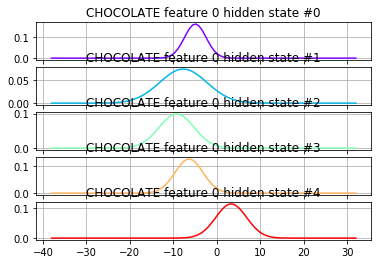

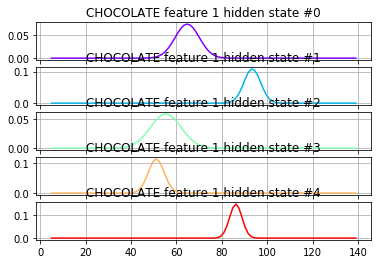

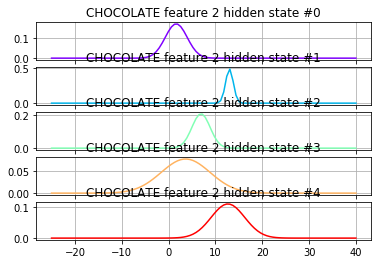

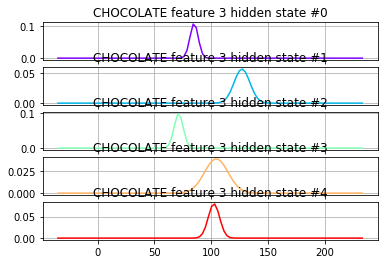

In [126]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance = np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    print(model.n_components)
    print(model.means_)
    print(model.covars_)
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()

visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [127]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'CHOCOLATE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for CHOCOLATE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [141]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
print(len(word_sequences))
print(word_sequences)
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

6
[[[-26, 52, 22, 134], [-26, 52, 22, 134], [-25, 46, 22, 134], [-25, 46, 22, 134], [-22, 42, 22, 134], [-24, 39, 20, 131], [-23, 40, 21, 132], [-21, 39, 21, 131], [-20, 38, 22, 130], [-21, 38, 21, 130], [-22, 37, 20, 129], [-20, 36, 22, 128], [-21, 37, 21, 129]], [[-22, 44, 26, 133], [-18, 40, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133], [-21, 36, 26, 133]], [[-20, 48, 26, 183], [-21, 46, 26, 183], [-20, 43, 30, 183], [-20, 43, 30, 183], [-18, 42, 32, 182], [-18, 38, 32, 178], [-15, 35, 35, 175], [-16, 36, 35, 175], [-14, 41, 35, 175], [-13, 38, 36, 172], [-13, 41, 36, 172], [-11, 39, 38, 170], [-16, 36, 38, 170]], [[-20, 36, -14, 126], [-22, 35, -14, 126], [-22, 35, -14, 126], [-21, 31, -14, 126], [-18, 30, -14, 126], [-15, 30, -14, 126], [-13, 30, -14, 126], [-13, 30, -14, 126], [-16, 28, -14, 126], [-16, 31, -14, 126], [-15, 33, -14, 126], [-15, 35, -14, 126], [-15, 35, -14, 126], [-16, 33, -14, 12

**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [129]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [130]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1, to load a training file with specified features
sequences = training.get_all_sequences() #self._data
Xlengths = training.get_all_Xlengths() #self._hmm_data

In [154]:
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

[[-25  42  -1  98]
 [-25  42   3  91]
 [-25  42   3  86]
 [-25  42   3  82]
 [-25  42   4  80]
 [-25  42   4  80]
 [-25  42   4  80]
 [-25  42   4  80]
 [-25  42   4  80]
 [-25  42   4  80]
 [-23  43   2  83]
 [-24  47   4  89]
 [-24  47   4  89]
 [-24  47   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]
 [-23  51   4  89]]
[11, 13]
[[[-25, 42, -1, 98], [-25, 42, 3, 91], [-25, 42, 3, 86], [-25, 42, 3, 82], [-25, 42, 4, 80], [-25, 42, 4, 80], [-25, 42, 4, 80], [-25, 42, 4, 80], [-25, 42, 4, 80], [-25, 42, 4, 80], [-23, 43, 2, 83]], [[-24, 47, 4, 89], [-24, 47, 4, 89], [-24, 47, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89], [-23, 51, 4, 89]]]
some indexes [1] [0]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

In [ ]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [ ]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [ ]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [ ]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [ ]:
# TODO Choose a feature set and model selector
features = features_ground # change as needed
model_selector = SelectorConstant # change as needed

# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features, model_selector)
test_set = asl.build_test(features)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [ ]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()